# Testing production and degradation on ABC

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

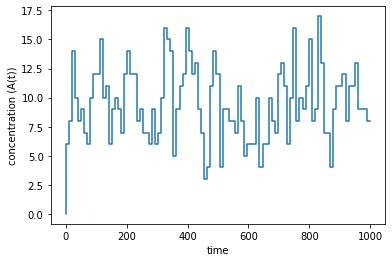

In [83]:
np.random.seed(7)

# Load a forward model
n_0 = 0
model = toy.stochastic.ProductionDegradationModel(n_0)

# Create some toy data
k = [0.1, 1]
times = np.linspace(0, 1000, 100)

values = model.simulate(k, times)
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)
# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0, 0.5], [0.3, 2])
# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

# Calculating the posterior

In [78]:
import math

# Single stationary distribution
def s_stationary(theta, n):
    fct = math.factorial(n)
    frac = theta[1] / theta[0]
    return (frac ** n) * np.exp(-frac) / fct

def p_stationary(theta, data):
    prod = 1.0
    for d in data:
        prod *= s_stationary(theta, d[0])
    return prod

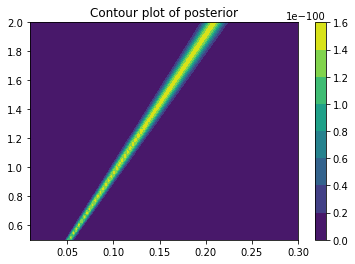

In [79]:
xlist = np.linspace(0.01, 0.3, 100)
ylist = np.linspace(0.5, 2, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = [[p_stationary([x, y], values[10:]) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Contour plot of posterior')
plt.show()

# Compute integral

In [80]:
from scipy import integrate

def f(x, y):
    return p_stationary([x, y], values[10:])

def bounds_x(y):
    return [0.0, 0.3]

def bounds_y():
    return [0.5, 2]

res = integrate.nquad(f, [bounds_x, bounds_y])

print("integral is ="+str(res))

def normalized_posterior(x, y):
    return p_stationary([x, y], values[10:]) / res[0]

new_approx = integrate.nquad(normalized_posterior, [bounds_x, bounds_y])

print("new integral should be 1="+str(new_approx))


integral is =(2.498010197350575e-102, 4.052072604427784e-102)
new integral should be 1=(0.9962292338141799, 1.5024042929100947e-08)


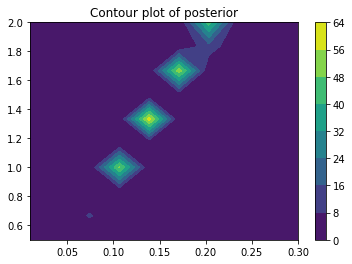

In [81]:
xlist = np.linspace(0.01, 0.3, 10)
ylist = np.linspace(0.5, 2, 10)
X, Y = np.meshgrid(xlist, ylist)
Z = [[normalized_posterior(x, y) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Contour plot of posterior')
plt.show()

# Compute marginal distributions

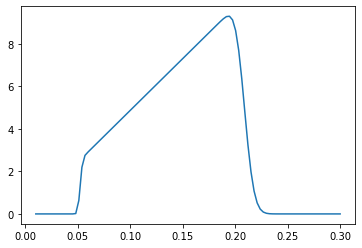

In [96]:
def marginal_distribution_x(x):
    partial_lam = lambda y : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0.5, 2)[0]

thetas = np.linspace(0.01, 0.3, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_x(theta))

plt.plot(thetas, results)
plt.show()

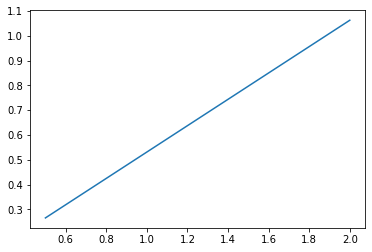

In [97]:
def marginal_distribution_y(y):
    partial_lam = lambda x : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0, 0.3)[0]

thetas = np.linspace(0.5, 2, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_y(theta))

plt.plot(thetas, results)
plt.show()

# Rejection ABC

In [103]:
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(4.4)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     22     0.0454545455     0:01.3
2     26     0.0769230769     0:01.5
3     41     0.0731707317     0:02.3
20    237    0.0843881857     0:11.8
40    438    0.0913242009     0:22.8
60    693    0.0865800866     0:35.3
80    863    0.0926998841     0:42.1
100   992    0.100806452      0:47.4
120   1161   0.103359173      0:54.4
140   1292   0.108359133      0:59.7
160   1499   0.106737825      1:08.5
180   1678   0.10727056       1:15.6
200   1993   0.100351229      1:28.3
220   2147   0.102468561      1:34.7
240   2426   0.098928277      1:45.7
260   2644   0.0983358548     1:54.4
280   2781   0.100683207      2:00.0
300   2995   0.100166945      2:09.2
320   3155   0.101426307      2:15.4
340   3306   0.102843315      2:21.8
360   3487   0.103240608      2:31.8
380   3617   0.105059442      2:38.5
400   3828   0.104493208      2:47.7
420   4070   0.103194103      2:58.7
440   4267   0.1

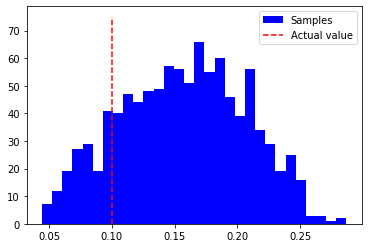

In [104]:
samples_flat = np.array([item for sublist in samples for item in sublist])

# print(samples_flat[:])
plt.hist(samples_flat[:,0], 30, color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=75, label="Actual value", color="red")
plt.legend()
plt.show()

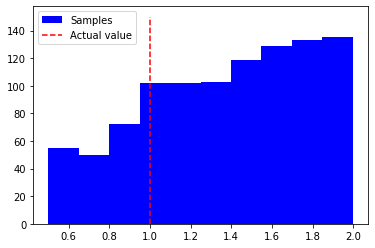

In [105]:
plt.hist(samples_flat[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=150, label="Actual value", color="red")
plt.legend()
plt.show()

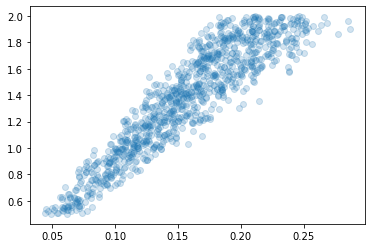

In [109]:
plt.scatter(samples_flat[:, 0], samples_flat[:, 1], alpha=0.2)
plt.show()

# PMC

In [3]:
np.random.seed(3)

abc = pints.ABCController(error_measure, log_prior, method=pints.ABCPMC)

# set the threshold
abc.sampler().set_threshold(4)

# set target number of samples
# try this
abc.set_n_samples(1000)

# setting the number of generations
abc.sampler().set_n_generations(10)

# setting the threshold ratio
abc.sampler().set_t_ratio(0.99)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using PMC ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     63344  0.0158026017    29:52.9
Halting: target number of samples (1001) reached.
Done


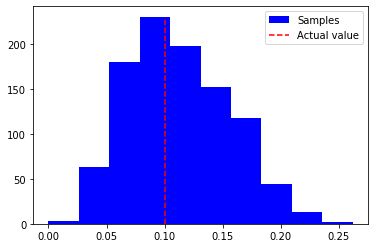

In [5]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=230, label="Actual value", color="red")
plt.legend()
plt.show()

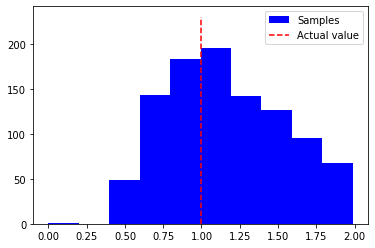

In [6]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=230, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

# ABC SMC

In [12]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([9, 6, 4]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=6
Trying t=2, threshold=4
Iter. Eval. Acceptance rate Time m:s
1     544    0.00183823529    0:02.3
2     548    0.00364963504    0:02.3
3     549    0.00546448087    0:02.3
20    623    0.0321027287     0:02.5
40    694    0.0576368876     0:02.7
60    771    0.0778210117     0:02.9
80    828    0.0966183575     0:03.1
100   893    0.111982083      0:03.3
120   966    0.124223602      0:03.5
140   1048   0.133587786      0:03.7
160   1122   0.142602496      0:03.9
180   1181   0.152413209      0:04.1
200   1239   0.1614205        0:04.3
220   1305   0.168582375      0:04.5
240   1403   0.17106201       0:04.7
260   1477   0.176032498      0:04.9
280   1549   0.180761782      0:05.1
300   1605   0.186915888      0:05.3
320   1681   0.190362879      0:05.5
340   1755   0.193732194      0:05.7
360   1827   0.197044335      0:05.9
380   1894   0.20063358       0:06.1
400   1965   0.203562341      0:06.3
420   2052   0.2046783

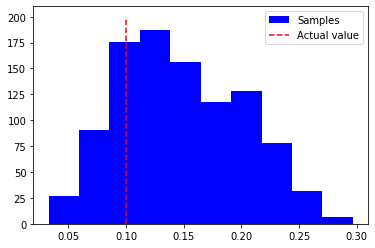

In [13]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

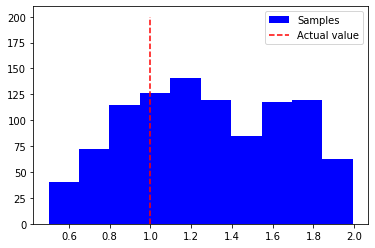

In [14]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

# Adaptive PMC ABC

In [9]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

# set threshold
abc.sampler().set_N_l(500)

# set p_acc_min
abc.sampler().set_p_acc_min(0.05)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.1700924  1.28768791]
epsilon=4.685082710048992
w_mean=[0.16528964 1.34771488]
epsilon=4.201190307520001
w_mean=[0.15819193 1.34440431]
epsilon=3.9306488014067096
w_mean=[0.14913046 1.3232475 ]
epsilon=3.7416573867739413
w_mean=[0.14728783 1.30087495]
epsilon=3.605551275463989
w_mean=[0.13950847 1.26636797]
epsilon=3.4856850115866753
w_mean=[0.13559672 1.24740463]
epsilon=3.398529093593286
w_mean=[0.13315816 1.22409532]
epsilon=3.3166247903554
w_mean=[0.12746868 1.19440579]
epsilon=3.263433774416144
w_mean=[0.12761929 1.19489162]
epsilon=3.2093613071762426
w_mean=[0.12501426 1.17639651]
epsilon=3.1622776601683795
w_mean=[0.12440638 1.16904729]
epsilon=3.122498999199199
w_mean=[0.12031688 1.13541359]
epsilon=3.0740852297878796
w_mean=[0.12017047 1.13620195]
epsilon=3.0413812651491097
w_mean=[0.12030749 1.13183294]
epsilon=3.0
w_mean=[0.1185371  1.11534026]
epsilon=2.9748949561287032
w_mean=[0.1185048  1.11762446]
eps

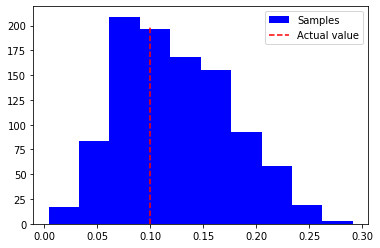

In [10]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
plt.legend()
plt.show()

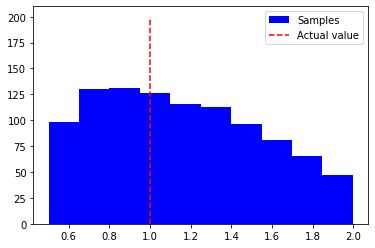

In [11]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
plt.legend()
plt.show()